In [177]:
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from numpy import random

import _pickle as cPickle

import os
from scipy.io import loadmat

## Part 1: Load data

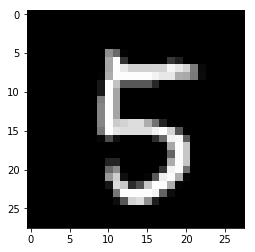

In [178]:
#Load the MNIST digit data
M = loadmat("mnist_all.mat")

#Display the 150-th "5" digit from the training set
imshow(M["train5"][150].reshape((28,28)), cmap=cm.gray)
show()

#print(M["train5"].shape)

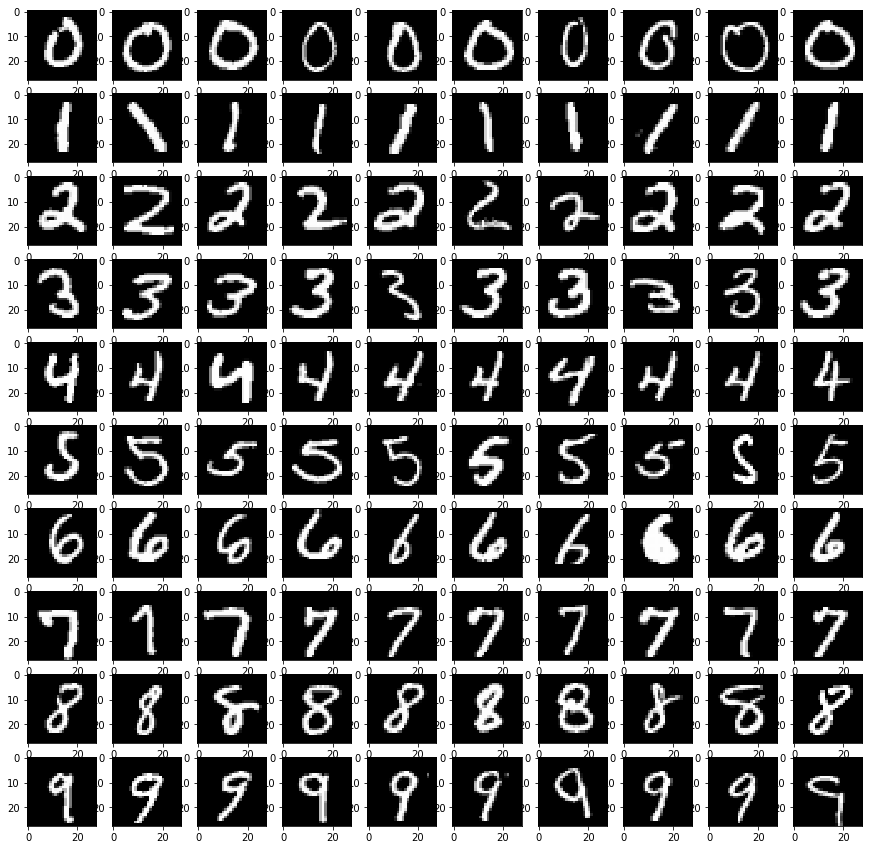

In [179]:
#Display 10 images of each digit
f, axarr = plt.subplots(10,10,figsize=(15,15))
plt.figure(figsize=(70,70))
for i in range(10):
    name = "train" + str(i)
    for j in range(10):
        axarr[i,j].imshow(M[name][j+20].reshape((28,28)), cmap=cm.gray)
plt.tight_layout()
plt.show()

## Part 2
Create neural network

Split up the data

In [180]:
# Generate matrices

# Generate Training Set
def generate_set(data_type):
    X = np.zeros((1,784)) #dummy row 
    Y = np.zeros((1,1)) #dummy row
    for i in range(10): #train0 ... train9
        name = data_type + str(i)
        X = np.vstack((X,M[name]))
        new_labels = np.ones((M[name].shape[0], 1)) * i
        Y = np.vstack((Y,new_labels))
    X = X[1:,:] / 255.0
    Y = Y[1:,:]
    #print("X_" + data_type + " shape", X.shape)
    #print("Y_" + data_type + " shape", Y.shape)
    return X, Y
    
#Scramble Training and Test Set
def scramble_set(X, Y):
    np.random.seed(2)
    p = np.random.permutation(X.shape[0]) #number of training examples
    return X[p], Y[p]


#Convert all labels to one hot
def one_hot_encoder(y, num_class):
    one_hot = []
    for elem in y:
        one_hot.append(np.eye(N = 1, M = num_class, k = int(elem)))
    one_hot = np.array(one_hot)
    return one_hot.reshape((len(one_hot), num_class))


In [181]:
#generate dataset
X_train, Y_train = generate_set("train")
X_test, Y_test = generate_set("test")

#scramble them
X_train, Y_train = scramble_set(X_train, Y_train)
X_test, Y_test = scramble_set(X_test, Y_test)

#conver the labels to one hot
Y_train = one_hot_encoder(Y_train, 10)
Y_test = one_hot_encoder(Y_test, 10)

#generate validation sets
X_validation = X_train[40000:,:] 
X_train = X_train[0:40000,:]

Y_validation = Y_train[40000:,:] 
Y_train = Y_train[0:40000,:]

print("X_train Shape: ", X_train.shape)
print("Y_train Shape: ", Y_train.shape)

print("X_validation Shape: ", X_validation.shape)
print("Y_validation Shape: ", Y_validation.shape)

print("X_test Shape: ", X_test.shape)
print("Y_test Shape: ", Y_test.shape)



X_train Shape:  (40000, 784)
Y_train Shape:  (40000, 10)
X_validation Shape:  (20000, 784)
Y_validation Shape:  (20000, 10)
X_test Shape:  (10000, 784)
Y_test Shape:  (10000, 10)


In [6]:
def softmax(Z):
    """
    Applies softmax to each row of Z
    """
    repeat = np.sum(exp(Z), axis=1).reshape((Z.shape[0],1))
    denom = np.tile(repeat, Z.shape[1])
    return np.exp(Z) / denom

def forward_prop(X, W, b):
    """
    Arguments:
    X, W, b

    Returns:
    Forward output 
    """
    Z = np.matmul(X,W) + b
    out = softmax(Z)
    return out

In [73]:
n = X_train.shape[1]
n_h = 10 #hidden layer neurons

W0 = np.random.randn(n, n_h) * 0.01
b0 = np.zeros(shape=(1, n_h))

print(X_train.shape)
out = forward_prop(X_train, W0, b0)
print("out matrix", out)
print("Checking if first row is normalized: ", (np.sum(out[2,:]) == 1.0))


(40000, 784)
out matrix [[ 0.10313355  0.09749684  0.10212973 ...,  0.10021397  0.09134571
   0.1094254 ]
 [ 0.09401057  0.09585641  0.10045346 ...,  0.09669917  0.09737479
   0.11125395]
 [ 0.1012243   0.08977369  0.09967886 ...,  0.10844982  0.08868879
   0.10006696]
 ..., 
 [ 0.0948327   0.10474649  0.09330671 ...,  0.09743522  0.09446404
   0.1063852 ]
 [ 0.09902367  0.1083958   0.08897067 ...,  0.09907855  0.08387621
   0.09907579]
 [ 0.1094035   0.09549639  0.09022986 ...,  0.10408873  0.08315723
   0.10860507]]
Checking if first row is normalized:  False


## Part 3a
Do in Latex

## Part 3b

In [606]:
def compute_grad(out, X, Y):
    m = X.shape[0]
    return np.matmul(X.T, (out - Y)) * (1/m)

def compute_grad_bias(out,X,Y):
    m = X.shape[0]
    return np.sum((out-Y), axis=0).reshape((1, out.shape[1])) * (1/m)  #sum over columns

def compute_cost(out,Y):
    m = Y.shape[0]
    return np.sum(Y * np.log(out)) * (-1/m)


In [593]:
def finite_diff(out, W, X, Y, b, perturbation = 0.05, sample_points=50):
    '''
    Returns average error after sampling a series of random points for W
    '''
    #finite_mat = np.empty((W.shape[0],W.shape[1]))
    total_pts = copy(sample_points)
    actual_grad = compute_grad(out,X,Y)
    orig_cost = compute_cost(out,Y)
    cum_fract_error = 0
    
    np.random.seed(2)
    while(sample_points > 0):
        #randomly pick coordinates
        row = np.random.randint(0,W.shape[0])
        col = np.random.randint(0,W.shape[1])
        
        #apply perturbation
        W[row][col] += perturbation
        new_out = forward_prop(X, W, b)

        approx_grad = (compute_cost(new_out,Y) - orig_cost)/ perturbation 
        cum_fract_error += np.abs(approx_grad - actual_grad[row][col]) / (1 + actual_grad[row][col])
        
        W[row][col] -= perturbation
        sample_points -= 1
        
    return cum_fract_error / float(total_pts)



In [594]:
#Testing compute_grad and compute_cost

#initialize variables
n = X_train.shape[1]
n_h = 10 #hidden layer neurons
np.random.seed(2)
W0 = np.random.randn(n, n_h) * 0.01
b0 = np.zeros(shape=(1, n_h))

#Compute output
out = forward_prop(X_train, W0, b0)

#Test gradient and cost functions
grad = compute_grad(out, X_train, Y_train)
print("Shape of Gradient ", grad.shape)
grad_bias = compute_grad_bias(out,X_train,Y_train)
print("Shape of Bias Gradient", grad_bias.shape)
cost = compute_cost(out, Y_train)
print("Current Cost ", cost)

#Testing finite_diff_error with gradient of W0
#X_temp = X_train[:10,:]
#Y_temp = Y_train[:10,:]
#out = forward_prop(X_train, W0, b0)

print("Average Fractional Error for W0", finite_diff(out, W0, X_train, Y_train, b0, perturbation = 0.05, sample_points=50))


Shape of Gradient  (784, 10)
Shape of Bias Gradient (1, 10)
Current Cost  2.31461201497
Average Fractional Error for W0 0.000246873652038


## Part 4
Compared 0.03 vs 0.3 learning rate. 0.3 converged faster without compromising convergence. 


In [420]:
def generate_mini_batches(X, Y, mini_batch_size):
    m = X.shape[0]
    X_mini_batch = []
    Y_mini_batch = []
    num_complete_minibatches = math.floor(m/mini_batch_size)
    
    for k in range(0, num_complete_minibatches):
        X_batch = X[k * mini_batch_size:(k + 1) * mini_batch_size,:]
        Y_batch = Y[k * mini_batch_size:(k + 1) * mini_batch_size,:]
        X_mini_batch.append(X_batch)
        Y_mini_batch.append(Y_batch)
    
    if m % mini_batch_size != 0:
        end = (k + 1) * mini_batch_size
        X_batch = X[end:,:]
        Y_batch = Y[end:,:]
        
    return X_mini_batch, Y_mini_batch


In [421]:
def compute_accuracy(X, Y, W, b):
    out = forward_prop(X, W, b)
    indicator = np.argmax(out, axis=1) == np.argmax(Y, axis = 1)
    return np.sum(indicator) / X.shape[0]


In [182]:
def nn_model_batches(X, Y, num_iterations=2000, learning_rate=0.05, print_cost=False):
    n = X.shape[1]
    n_h = 10 #hidden layer neurons
    
    np.random.seed(2)
    #initialize weight and bias matrix
    W0 = np.random.randn(n, n_h) * 0.01
    b0 = np.zeros(shape=(1, n_h))
    
    cost_list = []
    W0_list = []
    b0_list = []
    
    for i in range(0, num_iterations):
        #Forward Propagation
        out = forward_prop(X,W0,b0)  
        
        #Backward Propogation
        dW0 = compute_grad(out, X, Y)
        db0 = compute_grad_bias(out, X, Y)
        
        #Update 
        W0 = W0 - (learning_rate * dW0)
        b0 = b0 - (learning_rate * db0)
    
        #Compute Cost (print every 50 iterations)
        if (print_cost == True) and (i % 50 == 0):
            print("Cost after iteration {}: {}".format(i, compute_cost(out,Y)))
            cost_list.append(compute_cost(out,Y))
            W0_list.append(W0)
            b0_list.append(b0)
        elif (print_cost == False) and (i % 50 == 0):
            cost_list.append(compute_cost(out,Y))
            W0_list.append(W0)
            b0_list.append(b0)
        
    return cost_list, W0_list, b0_list


In [183]:
def nn_model(X, Y, XV, YV, num_iterations=2000, learning_rate=0.05, print_cost=False, 
            continue_training=False, W = [], b=[]):
    n = X.shape[1]
    n_h = 10 #hidden layer neurons
    
    np.random.seed(2)
    #initialize weight and bias matrix
    W0 = np.random.randn(n, n_h) * 0.01
    b0 = np.zeros(shape=(1, n_h))
    
    if (continue_training):
        W0 = W
        b0 = b
    
    cost_list = []
    W0_list = []
    b0_list = []
    
    for i in range(0, num_iterations):
        #Forward Propagation
        out = forward_prop(X,W0,b0)  
        
        #Backward Propogation
        dW0 = compute_grad(out, X, Y)
        db0 = compute_grad_bias(out, X, Y)
        
        #Update 
        W0 = W0 - (learning_rate * dW0)
        b0 = b0 - (learning_rate * db0)
    
        #Compute Cost (print every 50 iterations)
        if (print_cost == True) and (i % 50 == 0):
            print("Cost after iteration {}: {}".format(i, compute_cost(out,Y)))
            cost_list.append(compute_cost(out,Y))
            W0_list.append(W0)
            b0_list.append(b0)
            
            print("Accuracy on training set: ", compute_accuracy(X, Y, W0_list[-1], b0_list[-1]))
            print("Accuracy on validation set: ", compute_accuracy(XV, YV, W0_list[-1], b0_list[-1]))
            print('==='*5)
            
        elif (print_cost == False) and (i % 50 == 0):
            cost_list.append(compute_cost(out,Y))
            W0_list.append(W0)
            b0_list.append(b0)
            
        
    return cost_list, W0_list, b0_list


In [127]:
cost_GD, W0_GD, b0_GD = nn_model(X_train, Y_train, X_validation, Y_validation,
                                 num_iterations=10000, learning_rate=0.03, print_cost=True, 
                                 continue_training=False, W=W0_GD[-1], b=b0_GD[-1])

Cost after iteration 0: 2.314612014968709
Accuracy on training set:  0.161
Accuracy on validation set:  0.16695
Cost after iteration 50: 1.3450285161505418
Accuracy on training set:  0.7917
Accuracy on validation set:  0.7964
Cost after iteration 100: 0.9987688880574132
Accuracy on training set:  0.822725
Accuracy on validation set:  0.82535
Cost after iteration 150: 0.8355762499250816
Accuracy on training set:  0.83825
Accuracy on validation set:  0.83815
Cost after iteration 200: 0.7407338426188682
Accuracy on training set:  0.847475
Accuracy on validation set:  0.84695
Cost after iteration 250: 0.6781662247416769
Accuracy on training set:  0.854525
Accuracy on validation set:  0.85315
Cost after iteration 300: 0.6334042262585001
Accuracy on training set:  0.8594
Accuracy on validation set:  0.858
Cost after iteration 350: 0.5995502933306618
Accuracy on training set:  0.863025
Accuracy on validation set:  0.86205
Cost after iteration 400: 0.5728934759130245
Accuracy on training set: 

Accuracy on validation set:  0.8996
Cost after iteration 3100: 0.35065210095027544
Accuracy on training set:  0.904425
Accuracy on validation set:  0.89985
Cost after iteration 3150: 0.3497178858372953
Accuracy on training set:  0.904725
Accuracy on validation set:  0.9002
Cost after iteration 3200: 0.34880535061789775
Accuracy on training set:  0.905075
Accuracy on validation set:  0.9006
Cost after iteration 3250: 0.34791364771373434
Accuracy on training set:  0.905325
Accuracy on validation set:  0.9008
Cost after iteration 3300: 0.3470419755861678
Accuracy on training set:  0.905575
Accuracy on validation set:  0.90095
Cost after iteration 3350: 0.34618957556249746
Accuracy on training set:  0.90575
Accuracy on validation set:  0.9013
Cost after iteration 3400: 0.34535572892559185
Accuracy on training set:  0.90585
Accuracy on validation set:  0.9016
Cost after iteration 3450: 0.34453975424148575
Accuracy on training set:  0.90595
Accuracy on validation set:  0.9019
Cost after iter

Cost after iteration 6150: 0.3162594022523826
Accuracy on training set:  0.913575
Accuracy on validation set:  0.90835
Cost after iteration 6200: 0.31591286330411195
Accuracy on training set:  0.91355
Accuracy on validation set:  0.90835
Cost after iteration 6250: 0.31557031145003805
Accuracy on training set:  0.913625
Accuracy on validation set:  0.90835
Cost after iteration 6300: 0.3152316682223004
Accuracy on training set:  0.913725
Accuracy on validation set:  0.90845
Cost after iteration 6350: 0.3148968573160716
Accuracy on training set:  0.913875
Accuracy on validation set:  0.9085
Cost after iteration 6400: 0.31456580451299104
Accuracy on training set:  0.91395
Accuracy on validation set:  0.90855
Cost after iteration 6450: 0.31423843760790193
Accuracy on training set:  0.914
Accuracy on validation set:  0.90855
Cost after iteration 6500: 0.3139146863387238
Accuracy on training set:  0.914025
Accuracy on validation set:  0.9087
Cost after iteration 6550: 0.3135944823193033
Accur

Cost after iteration 9250: 0.3002013842441834
Accuracy on training set:  0.917175
Accuracy on validation set:  0.9116
Cost after iteration 9300: 0.30000712545717745
Accuracy on training set:  0.91725
Accuracy on validation set:  0.91185
Cost after iteration 9350: 0.2998143325865518
Accuracy on training set:  0.9173
Accuracy on validation set:  0.9119
Cost after iteration 9400: 0.2996229864050626
Accuracy on training set:  0.91735
Accuracy on validation set:  0.91195
Cost after iteration 9450: 0.2994330680392159
Accuracy on training set:  0.917425
Accuracy on validation set:  0.91205
Cost after iteration 9500: 0.29924455896092794
Accuracy on training set:  0.9175
Accuracy on validation set:  0.91205
Cost after iteration 9550: 0.29905744097942516
Accuracy on training set:  0.917575
Accuracy on validation set:  0.91215
Cost after iteration 9600: 0.2988716962333754
Accuracy on training set:  0.917575
Accuracy on validation set:  0.9123
Cost after iteration 9650: 0.29868730718324416
Accurac

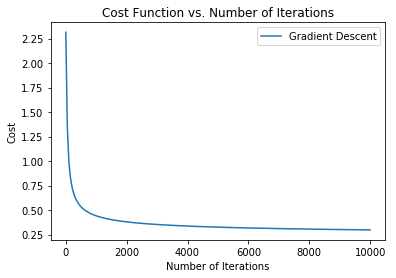

In [128]:
#Plotting perfromance of GD with momentum vs GB without momentum
iterations = np.linspace(0,50*len(cost_GD),len(cost_GD))

plt.plot(iterations, cost_GD, label='Gradient Descent')
plt.title('Cost Function vs. Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.legend()
plt.show()


In [130]:
print("Accuracy on training set: ", compute_accuracy(X_train, Y_train, W0_GD[-1], b0_GD[-1]))
print("Accuracy on validaton set: ", compute_accuracy(X_validation, Y_validation, W0_GD[-1], b0_GD[-1]))
print("Accuracy on test set: ", compute_accuracy(X_test, Y_test, W0_GD[-1], b0_GD[-1]))

Accuracy on training set:  0.91795
Accuracy on validaton set:  0.91265
Accuracy on test set:  0.9174


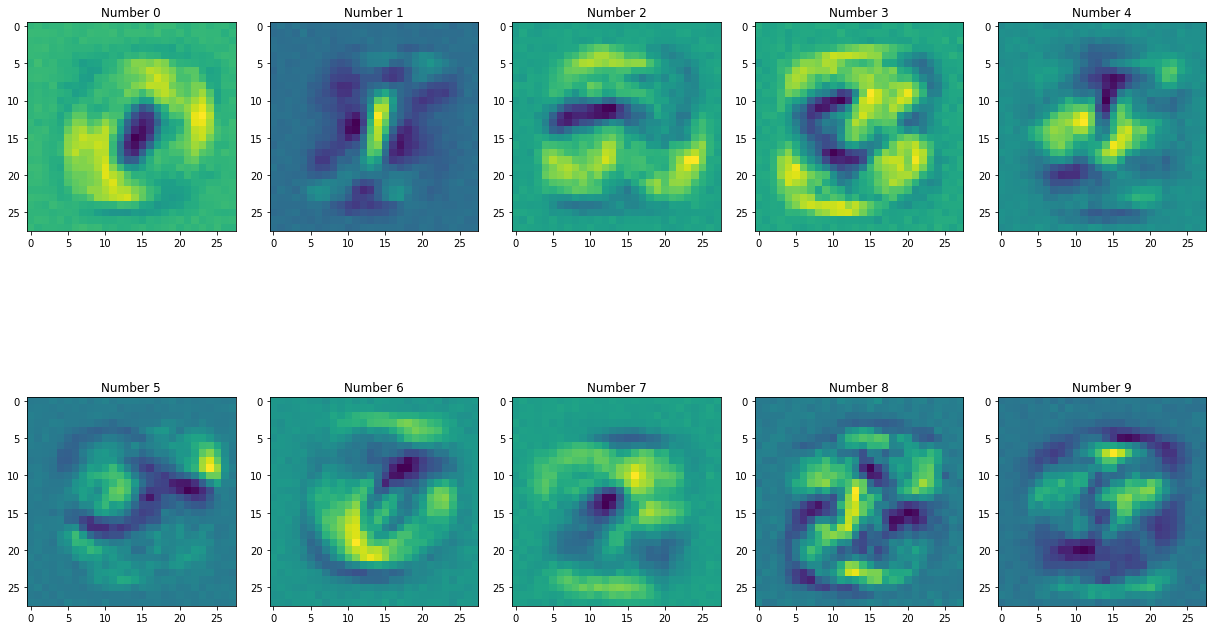

In [131]:
final_weights = W0_GD[-1]

f, axarr = plt.subplots(2,5,figsize=(17,17))
for i in range(10):
    row = int(i > 4)
    col = i % 5
    img = final_weights[:,i].T.reshape((28,28))
    axarr[row, col].imshow(img)
    axarr[row, col].set_title("Number "+ str(i))
    plt.tight_layout()

plt.show()


In [387]:
cost_GD2, W0_GD2, b0_GD2 = nn_model(X_train, Y_train, X_validation, Y_validation,
                                 num_iterations=2000, learning_rate=0.3, print_cost=True, 
                                 continue_training=False, W=W0_GD[-1], b=b0_GD[-1])


Cost after iteration 0: 2.314612014968709
Accuracy on training set:  0.62355
Accuracy on validation set:  0.62655
Cost after iteration 50: 0.5307910893062449
Accuracy on training set:  0.8719
Accuracy on validation set:  0.8703
Cost after iteration 100: 0.4398430400438649
Accuracy on training set:  0.886325
Accuracy on validation set:  0.8839
Cost after iteration 150: 0.40151669797696865
Accuracy on training set:  0.893625
Accuracy on validation set:  0.89055
Cost after iteration 200: 0.37902039542709126
Accuracy on training set:  0.898525
Accuracy on validation set:  0.89465
Cost after iteration 250: 0.3637275898531189
Accuracy on training set:  0.90175
Accuracy on validation set:  0.8975
Cost after iteration 300: 0.3524265077168751
Accuracy on training set:  0.904025
Accuracy on validation set:  0.89965
Cost after iteration 350: 0.34361275788458395
Accuracy on training set:  0.906125
Accuracy on validation set:  0.90195
Cost after iteration 400: 0.33647510758728877
Accuracy on traini

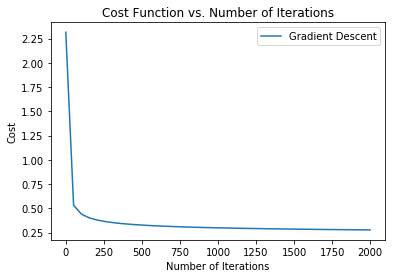

In [133]:
#Plotting perfromance of GD with momentum vs GB without momentum
iterations = np.linspace(0,50*len(cost_GD2),len(cost_GD2))

plt.plot(iterations, cost_GD2, label='Gradient Descent')
plt.title('Cost Function vs. Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.legend()
plt.show()

In [135]:
print("Accuracy on training set: ", compute_accuracy(X_train, Y_train, W0_GD2[-1], b0_GD2[-1]))
print("Accuracy on validaton set: ", compute_accuracy(X_validation, Y_validation, W0_GD2[-1], b0_GD2[-1]))
print("Accuracy on test set: ", compute_accuracy(X_test, Y_test, W0_GD2[-1], b0_GD2[-1]))

Accuracy on training set:  0.923075
Accuracy on validaton set:  0.9165
Accuracy on test set:  0.9195


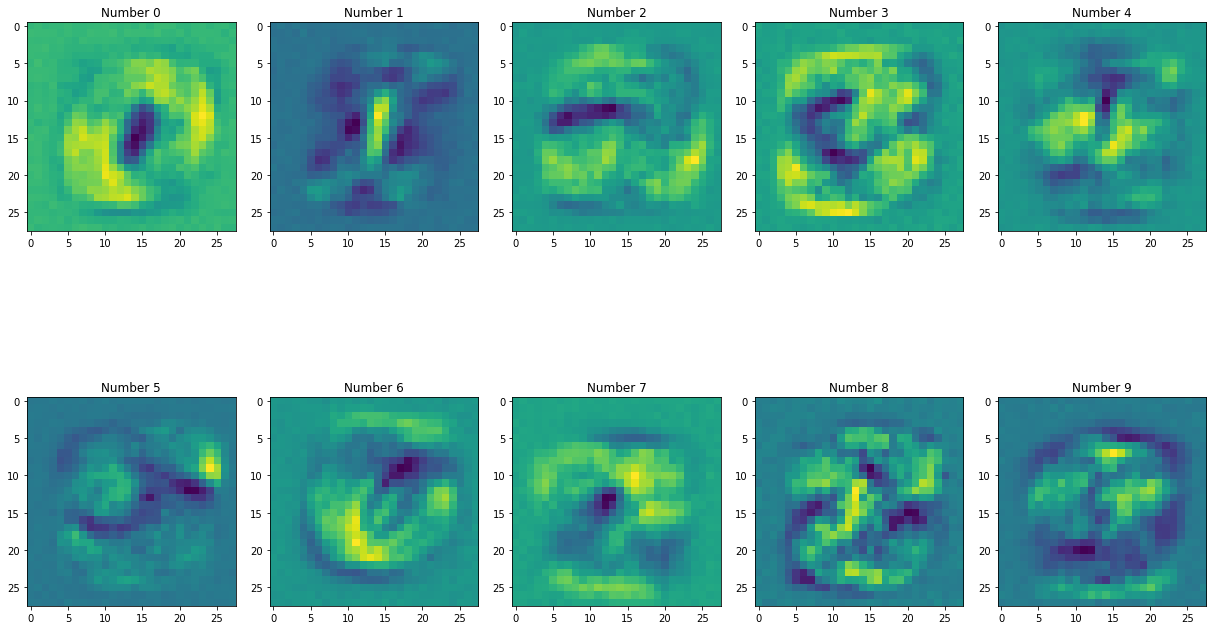

In [526]:
final_weights = W0_GD2[-1]

f, axarr = plt.subplots(2,5,figsize=(17,17))
for i in range(10):
    row = int(i > 4)
    col = i % 5
    img = final_weights[:,i].T.reshape((28,28))
    axarr[row, col].imshow(img)
    axarr[row, col].set_title("Number "+ str(i))
    plt.tight_layout()

plt.show()


## Part 5: Gradient Descent with Momentum

In [ ]:
def nn_model_momentum_batches(X, Y, num_iterations=200, learning_rate=0.05, print_cost=False):
    n = X.shape[1]
    n_h = 10 #hidden layer neurons
    
    np.random.seed(2)
    
    #initialize weight and bias matrix
    W0 = np.random.randn(n, n_h) * 0.01
    b0 = np.zeros(shape=(1, n_h))
    
    #initialize parameters for momentum GD
    vdW0 = np.zeros_like(W0)
    vdb0 = np.zeros_like(b0)
    beta = 0.90
    
    cost_list = []
    W0_list = []
    b0_list = []
    
    X_batches, Y_batches = generate_mini_batches(X, Y, mini_batch_size=64)

    for i in range(0, num_iterations):
        for j in range(len(X_batches)):
            X_batch = X_batches[j]
            Y_batch = Y_batches[j]
        
            #Forward Propagation
            out = forward_prop(X,W0,b0)  

            #Backward Propogation
            dW0 = compute_grad(out, X, Y)
            db0 = compute_grad_bias(out, X, Y)

            vdW0 = (beta*vdW0) + (1-beta)*dW0
            vdb0 = (beta*vdb0) + (1-beta)*db0

            #Update 
            W0 = W0 - (learning_rate * vdW0)
            b0 = b0 - (learning_rate * vdb0)

            #Compute Cost (print every 50 iterations)
        if (print_cost == True) and (i % 50 == 0):
            print("Cost after iteration {}: {}".format(i, compute_cost(out,Y)))
            cost_list.append(compute_cost(out,Y))
            W0_list.append(W0)
            b0_list.append(b0)
        elif (print_cost == False) and (i % 50 == 0):
            cost_list.append(compute_cost(out,Y))
            W0_list.append(W0)
            b0_list.append(b0)
            
    return cost_list, W0_list, b0_list


In [192]:
def nn_model_momentum(X, Y, XV, YV, 
                      num_iterations=200, learning_rate=0.05, 
                      print_cost=False):
    n = X.shape[1]
    n_h = 10 #hidden layer neurons
    
    np.random.seed(2)
    
    #initialize weight and bias matrix
    W0 = np.random.randn(n, n_h) * 0.01
    b0 = np.zeros(shape=(1, n_h))
    
    #initialize parameters for momentum GD
    vdW0 = np.zeros_like(W0)
    vdb0 = np.zeros_like(b0)
    beta = 0.99
    
    cost_list = []
    W0_list = []
    b0_list = []
    
    for i in range(0, num_iterations):
        #Forward Propagation
        out = forward_prop(X,W0,b0)  
        
        #Backward Propogation
        dW0 = compute_grad(out, X, Y)
        db0 = compute_grad_bias(out, X, Y)
        
        vdW0 = (beta*vdW0) + (1-beta)*dW0
        vdb0 = (beta*vdb0) + (1-beta)*db0
        
        #Update 
        W0 = W0 - (learning_rate * vdW0)
        b0 = b0 - (learning_rate * vdb0)
    
        #Compute Cost (print every 50 iterations)
        if (print_cost == True) and (i % 50 == 0):
            print("Cost after iteration {}: {}"
                  .format(i, compute_cost(out,Y)))
            cost_list.append(compute_cost(out,Y))
            W0_list.append(W0)
            b0_list.append(b0)
            
            print("Accuracy on training set: ", 
                  compute_accuracy(X, Y, W0_list[-1], b0_list[-1]))
            print("Accuracy on validation set: ", 
                  compute_accuracy(XV, YV, W0_list[-1], b0_list[-1]))
            print('==='*5)
            
        elif (print_cost == False) and (i % 50 == 0):
            cost_list.append(compute_cost(out,Y))
            W0_list.append(W0)
            b0_list.append(b0)
            
    return cost_list, W0_list, b0_list


In [388]:
cost_GD_mom, W0_GD_mom, b0_GD_mom = nn_model_momentum(X_train, Y_train, X_validation, Y_validation, 
                                                      num_iterations=2000, learning_rate=0.03, print_cost=True)

Cost after iteration 0: 2.314612014968709
Accuracy on training set:  0.094225
Accuracy on validation set:  0.097
Cost after iteration 50: 1.9932102350238283
Accuracy on training set:  0.67115
Accuracy on validation set:  0.6779
Cost after iteration 100: 1.4404525051190227
Accuracy on training set:  0.7526
Accuracy on validation set:  0.75615
Cost after iteration 150: 1.0323775613130748
Accuracy on training set:  0.798575
Accuracy on validation set:  0.80465
Cost after iteration 200: 0.8130493523293677
Accuracy on training set:  0.819775
Accuracy on validation set:  0.8232
Cost after iteration 250: 0.6935956563782838
Accuracy on training set:  0.832125
Accuracy on validation set:  0.834
Cost after iteration 300: 0.6237898720108171
Accuracy on training set:  0.84135
Accuracy on validation set:  0.8419
Cost after iteration 350: 0.5792546554834005
Accuracy on training set:  0.8493
Accuracy on validation set:  0.84855
Cost after iteration 400: 0.5481679010726646
Accuracy on training set:  0

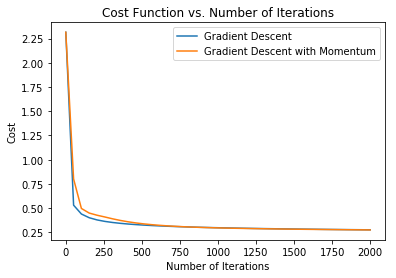

In [190]:
#Plotting perfromance of GD with momentum vs GB without momentum
iterations = np.linspace(0,50*len(cost_GD2),len(cost_GD2))

plt.plot(iterations, cost_GD2, label='Gradient Descent')
plt.plot(iterations, cost_GD_mom, label='Gradient Descent with Momentum')
plt.title('Cost Function vs. Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Cost')
plt.legend()
plt.show()


In [446]:
#saving final weights for part 6
W0f = W0_GD2[-1]
b0f = b0_GD2[-1]
print(W0f)
print(b0f)

(784, 10)
[[-0.39399835  0.28782509  0.16600042 -0.33951602  0.05317093  1.37354148
  -0.0659678   0.65592913 -1.4423894  -0.29459549]]


Part 6a
Produce Contour plots of cost function 

In [549]:
def get_loss(w1, w2, w1_val, w2_val, W0, b0, X, Y):
    W0 = np.copy(W0)
    b0 = np.copy(b0)
    
    W0[w1[0], w1[1]] = w1_val
    W0[w2[0], w2[1]] = w2_val

    out = forward_prop(X, W0, b0)
    return compute_cost(out,Y)


0.37319013669
0.179639451756


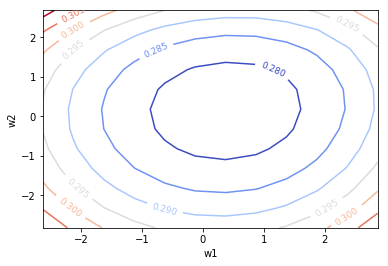

18.278306007385254


In [595]:

w1 = [295, 7]
w2 = [684, 3]

w1_val_f = W0f[w1[0], w1[1]]
w2_val_f = W0f[w2[0], w2[1]]

print(W0f[w1[0], w1[1]])
print(W0f[w2[0], w2[1]])

import time
start = time.time()
w1s = np.arange(w1_val_f - 3, w1_val_f +3, 0.5)
w2s = np.arange(w2_val_f - 3, w2_val_f + 3, 0.5)
w1z, w2z = np.meshgrid(w1s, w2s)
C = np.zeros([w1s.size, w2s.size])
for i, w1_val in enumerate(w1s):
    for j, w2_val in enumerate(w2s):
        C[j,i] = get_loss(w1, w2, w1_val, w2_val, W0f, b0f, X_train, Y_train)
CS = plt.contour(w1z, w2z, C, cmap=cm.coolwarm)
plt.clabel(CS, fontsize=9, inline=1)
plt.xlabel('w1')
plt.ylabel('w2')

plt.show()
plt.savefig('images/contour.png')
print(time.time() - start)

In [578]:
def nn_model_two_weight_mom(X, Y, w1, w2, w1_val, w2_val, 
                        W0_final, b0_final, num_iterations=10, 
                        learning_rate=1, print_cost=False, beta = 0):
    
    w_list = []
    
    W0 = np.copy(W0_final)
    b0 = np.copy(b0_final)
    W0[w1[0], w1[1]] = w1_val
    W0[w2[0], w2[1]] = w2_val
    
    #beta = 0.90
    vdw1 = w1_val
    vdw2 = w2_val
    
    for i in range(num_iterations):
        prev_W0 = np.copy(W0)
         #Forward Propagation
        out = forward_prop(X,W0,b0)  
        #Backward Propogation
        dW0 = compute_grad(out, X, Y)
        
        vdw1 = beta * vdw1 + (1-beta)*dW0[w1[0], w1[1]]
        vdw2 = beta * vdw2 + (1-beta)*dW0[w2[0], w2[1]]
        
        
        W0[w1[0], w1[1]] -= learning_rate * vdw1
        W0[w2[0], w2[1]] -= learning_rate * vdw2
        
        
        w_list.append((W0[w1[0], w1[1]], W0[w2[0], w2[1]]))
        
        out = forward_prop(X,W0,b0)  
        print(compute_cost_new(out,Y))
        print("w1: ", W0[w1[0], w1[1]])
        print("w2: ", W0[w2[0], w2[1]])
        print('***' * 5)
        
    return w_list

In [609]:
# w1_val = -1
# w2_val = 1

#showing benefit of momentum
w1_val = w1_val_f + 1.5
w2_val = w2_val_f + 1.5

w_list_mom0 = nn_model_two_weight_mom(X_train, Y_train, w1, w2, w1_val, w2_val, 
                        W0, b0, num_iterations=20, 
                        learning_rate=0.1, print_cost=False,beta=0)

print("======" * 5)

w_list_mom1 = nn_model_two_weight_mom(X_train, Y_train, w1, w2, w1_val, w2_val, 
                        W0, b0, num_iterations=20, 
                        learning_rate=0.1, print_cost=False,beta=0.9)

-2.35781601696
w1:  1.86677354169
w2:  1.67691613926
***************
-2.35733691623
w1:  1.86039661677
w2:  1.67419959126
***************
-2.35686317019
w1:  1.85405905915
w2:  1.67148980439
***************
-2.35639470914
w1:  1.84776056846
w2:  1.66878677502
***************
-2.35593146437
w1:  1.84150084671
w2:  1.66609049926
***************
-2.35547336815
w1:  1.83527959831
w2:  1.66340097299
***************
-2.35502035371
w1:  1.82909653
w2:  1.66071819181
***************
-2.35457235521
w1:  1.8229513509
w2:  1.6580421511
***************
-2.35412930776
w1:  1.81684377249
w2:  1.65537284599
***************
-2.3536911474
w1:  1.81077350857
w2:  1.65271027139
***************
-2.35325781106
w1:  1.80474027525
w2:  1.65005442196
***************
-2.35282923658
w1:  1.79874379099
w2:  1.64740529214
***************
-2.35240536265
w1:  1.79278377653
w2:  1.64476287615
***************
-2.35198612888
w1:  1.7868599549
w2:  1.64212716799
***************
-2.3515714757
w1:  1.78097205141
w2:  1.6

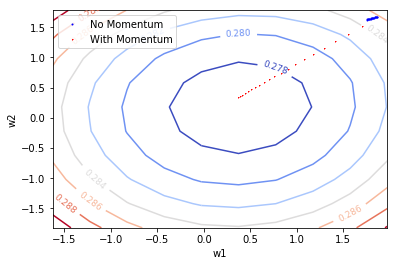

12.676115036010742


In [614]:
import time
start = time.time()
w1s = np.arange(w1_val_f - 2, w1_val_f + 2, 0.4)
w2s = np.arange(w2_val_f - 2, w2_val_f + 2, 0.4)
w1z, w2z = np.meshgrid(w1s, w2s)
C = np.zeros([w1s.size, w2s.size])
for i, w1_val in enumerate(w1s):
    for j, w2_val in enumerate(w2s):
        C[j,i] = get_loss(w1, w2, w1_val, w2_val, W0f, b0f, X_train, Y_train)
CS = plt.contour(w1z, w2z, C, cmap=cm.coolwarm)
plt.plot([a for a, b in w_list_mom0], [b for a,b in w_list_mom0], 'bo', markersize=1, label="No Momentum")
plt.plot([a for a, b in w_list_mom1], [b for a,b in w_list_mom1], 'r+', markersize=1, label="With Momentum")

plt.clabel(CS, fontsize=9, inline=1)
plt.legend(loc='upper left')
plt.xlabel('w1')
plt.ylabel('w2')

plt.show()
plt.savefig('images/contour_plot.png')
print(time.time() - start)

In [632]:
# w1 = [348, 8]
# w2 = [684, 3]
w1 = [28, 6]
w2 = [0, 5]

w1_val_f = W0f[w1[0], w1[1]]
w2_val_f = W0f[w2[0], w2[1]]

print(W0f[w1[0], w1[1]])
print(W0f[w2[0], w2[1]])

w1_val = w1_val_f - 0.4
w2_val = w2_val_f + 0.4

w_list_mom0 = nn_model_two_weight_mom(X_train, Y_train, w1, w2, w1_val, w2_val, 
                        W0, b0, num_iterations=20, 
                        learning_rate=0.1, print_cost=False,beta=0)

print("======" * 5)

w_list_mom1 = nn_model_two_weight_mom(X_train, Y_train, w1, w2, w1_val, w2_val, 
                        W0, b0, num_iterations=20, 
                        learning_rate=0.1, print_cost=False,beta=0.9)



0.000325654693125
-0.00841747365656
-2.31461201497
w1:  -0.399674345307
w2:  0.391582526343
***************
-2.31461201497
w1:  -0.399674345307
w2:  0.391582526343
***************
-2.31461201497
w1:  -0.399674345307
w2:  0.391582526343
***************
-2.31461201497
w1:  -0.399674345307
w2:  0.391582526343
***************
-2.31461201497
w1:  -0.399674345307
w2:  0.391582526343
***************
-2.31461201497
w1:  -0.399674345307
w2:  0.391582526343
***************
-2.31461201497
w1:  -0.399674345307
w2:  0.391582526343
***************
-2.31461201497
w1:  -0.399674345307
w2:  0.391582526343
***************
-2.31461201497
w1:  -0.399674345307
w2:  0.391582526343
***************
-2.31461201497
w1:  -0.399674345307
w2:  0.391582526343
***************
-2.31461201497
w1:  -0.399674345307
w2:  0.391582526343
***************
-2.31461201497
w1:  -0.399674345307
w2:  0.391582526343
***************
-2.31461201497
w1:  -0.399674345307
w2:  0.391582526343
***************
-2.31461201497
w1:  -0.39967

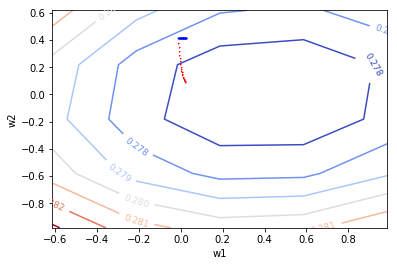

2.90506911277771


In [631]:
start = time.time()
w1s = np.arange(w1_val_f - 1, w1_val_f + 1, 0.4)
w2s = np.arange(w2_val_f - 1, w2_val_f + 1, 0.4)
w1z, w2z = np.meshgrid(w1s, w2s)
C = np.zeros([w1s.size, w2s.size])
for i, w1_val in enumerate(w1s):
    for j, w2_val in enumerate(w2s):
        C[j,i] = get_loss(w1, w2, w1_val, w2_val, W0f, b0f, X_train, Y_train)
CS = plt.contour(w1z, w2z, C, cmap=cm.coolwarm)
plt.plot([a for a, b in w_list_mom0], [b for a,b in w_list_mom0], 'bo', markersize=1, label="No Momentum")
plt.plot([a for a, b in w_list_mom1], [b for a,b in w_list_mom1], 'r+', markersize=1, label="With Momentum")

plt.clabel(CS, fontsize=9, inline=1)
#plt.legend(loc='upper left')
plt.xlabel('w1')
plt.ylabel('w2')

plt.show()
#plt.savefig('images/contour_plot.png')
print(time.time() - start)
